# **Домашная работа №8**

## **Рассмотрим кейс с рекламной выручкой**

### **Загрузка библиотек**

In [1]:
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

### **Рассмотрим кейс с рекламной выручкой**

In [2]:
data = pd.read_excel('gb_sem_8_hm.xlsx')

C:\Users\5\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
data.shape

(10000, 3)

In [6]:
data.USER_ID.nunique()

6324

In [7]:
data = data.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [8]:
data.shape

(7865, 3)

In [9]:
data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [10]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [11]:
new_data = data[data['REVENUE']>0] # строки где выручка больше 0
new_data

,USER_ID,VARIANT_NAME,REVENUE
37,56,variant,2.99
89,124,control,1.25
125,169,control,4.33
211,282,control,18.56
314,403,variant,1.99
...,...,...,...
7617,9669,variant,1.99
7693,9766,control,3.79
7807,9928,variant,1.25
7822,9942,variant,3.25


In [12]:
new_data[data['VARIANT_NAME']=='variant'].describe()

C:\Users\5\AppData\Local\Temp\ipykernel_12740\2210404123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_data[data['VARIANT_NAME']=='variant'].describe()


,USER_ID,REVENUE
count,71.000000,71.000000
mean,5270.267606,4.950282
std,3123.025987,9.971103
min,56.000000,0.020000
25%,2648.000000,1.240000
50%,5597.000000,2.240000
75%,8012.500000,3.975000
max,9996.000000,58.630000


In [13]:
new_data[data['VARIANT_NAME']=='control'].describe()

C:\Users\5\AppData\Local\Temp\ipykernel_12740\2307502792.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_data[data['VARIANT_NAME']=='control'].describe()


,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


### **Применение статистических критериев**

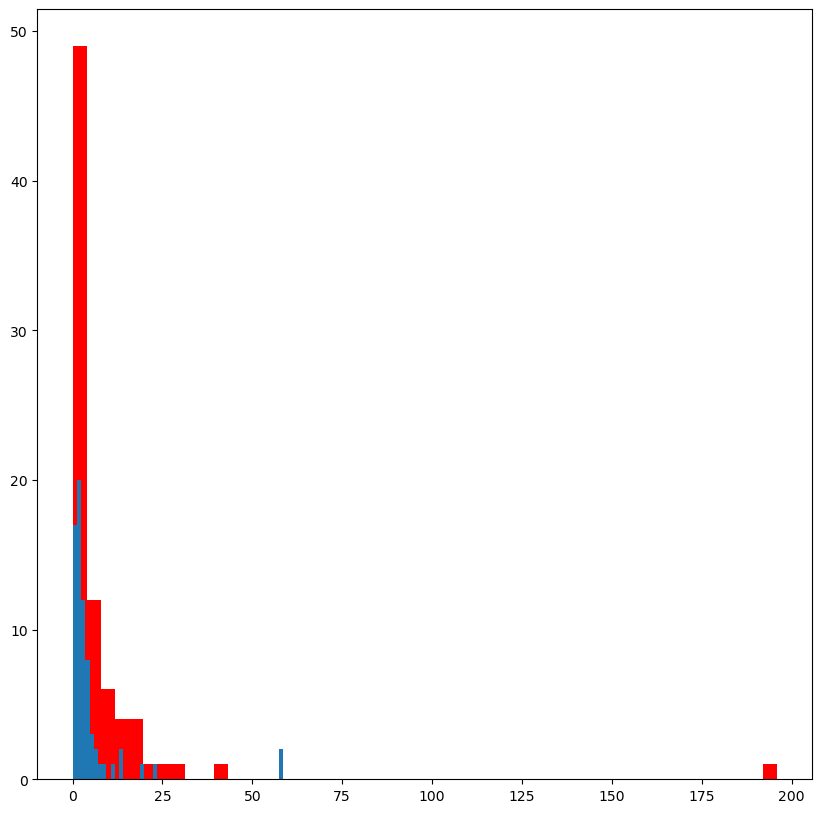

In [14]:
# График распределения
plt.figure(figsize=(10, 10))
control_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [15]:
# Проверка на нормальность тест Колмогорова-Смирнова
from scipy.stats import kstest
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.7443502263331446, pvalue=3.4769340937348253e-46)
KstestResult(statistic=0.6864151686037542, pvalue=8.28107008507227e-34)


pvalue > 0.05
Принимаем 0 гипотезу значемых изменений нет.

In [16]:
# Расчет стат значимости Манна Уитни
from scipy.stats import mannwhitneyu
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=3273.0, pvalue=0.10678659163407059)

pvalue > 0.05
Принимаем 0 гипотезу значемых изменений нет.

In [18]:
# Функция бутстрепа
from scipy.stats import norm

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

     

In [19]:
# Функция бутстрепа
from scipy.stats import norm

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

     

100%|██████████| 10000/10000 [00:25<00:00, 387.56it/s]


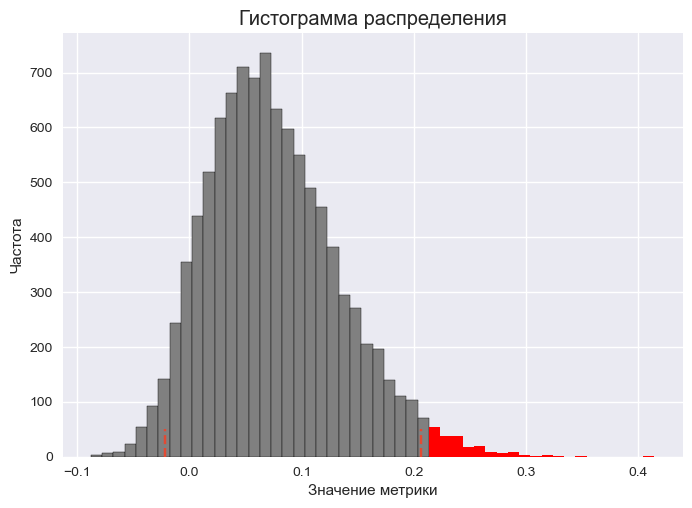

p_value 0.2047586912228032


In [20]:
plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format
# если 0 включен в доверительный интервал между группами нет разницы
# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(data['REVENUE'][data['VARIANT_NAME']=='control'],
                            data['REVENUE'][data['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

p_value > 0.05
Нет стат. значимости.

Мы проанализируйте результаты эксперимента и рекомендуем менеджеру, что расскатывать тест не нужно. Победил контрольный тест.